# Investigate Why Zero-Shot Detection is Failing

The debugging shows it should work, but in practice it's missing example forms.
Let's dig deeper into what's happening.

In [1]:
# Setup
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch
from transformers import CLIPProcessor, CLIPModel
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import fitz
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load CLIP model
model_name = "openai/clip-vit-large-patch14-336"
clip_model = CLIPModel.from_pretrained(model_name)
clip_processor = CLIPProcessor.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
clip_model = clip_model.to(device)
clip_model.eval()

print(f"Model loaded on {device}")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Model loaded on mps


In [5]:
# Load ALL example forms and extract features
example_forms_dir = "../../data/raw/_exampleforms/"
example_files = [f for f in os.listdir(example_forms_dir) if f.endswith('.pdf')]
print(f"Found {len(example_files)} example forms")

example_features = []
example_names = []

for example_file in example_files:
    try:
        pdf_path = os.path.join(example_forms_dir, example_file)
        pdf = fitz.open(pdf_path)
        page = pdf[0]
        pix = page.get_pixmap()
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        pdf.close()
        
        # Extract features
        inputs = clip_processor(images=img, return_tensors="pt").to(device)
        with torch.no_grad():
            features = clip_model.get_image_features(**inputs)
            features = features.cpu().numpy()
            features = features / np.linalg.norm(features, axis=1, keepdims=True)
            
        example_features.append(features)
        example_names.append(example_file)
        
    except Exception as e:
        print(f"Error loading {example_file}: {e}")

print(f"Successfully loaded {len(example_features)} examples")

Found 32 example forms
Successfully loaded 32 examples


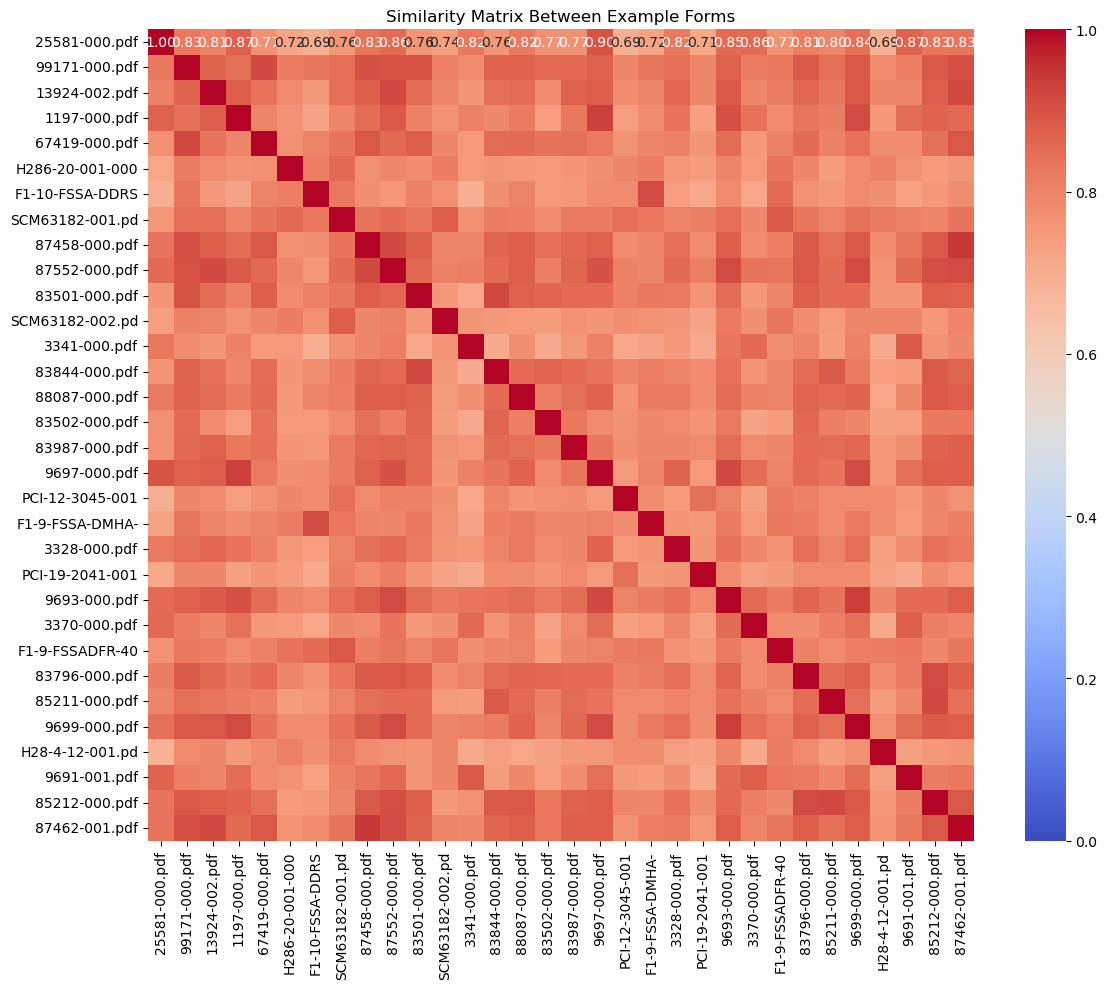


Example forms similarity statistics:
Average similarity: 0.812
Min similarity: 0.687
Max similarity: 0.944

If examples are too diverse (low avg similarity), detection will be harder


In [7]:
# Create similarity matrix between all examples
n_examples = len(example_features)
similarity_matrix = np.zeros((n_examples, n_examples))

for i in range(n_examples):
    for j in range(n_examples):
        sim = cosine_similarity(example_features[i], example_features[j])[0][0]
        similarity_matrix[i, j] = sim

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_matrix, 
            xticklabels=[name[:15] for name in example_names],
            yticklabels=[name[:15] for name in example_names],
            annot=True, fmt='.2f', cmap='coolwarm',
            vmin=0, vmax=1)
plt.title("Similarity Matrix Between Example Forms")
plt.tight_layout()
plt.show()

# Statistics
np.fill_diagonal(similarity_matrix, np.nan)  # Exclude self-similarity
avg_similarity = np.nanmean(similarity_matrix)
min_similarity = np.nanmin(similarity_matrix)
max_similarity = np.nanmax(similarity_matrix)

print(f"\nExample forms similarity statistics:")
print(f"Average similarity: {avg_similarity:.3f}")
print(f"Min similarity: {min_similarity:.3f}")
print(f"Max similarity: {max_similarity:.3f}")
print(f"\nIf examples are too diverse (low avg similarity), detection will be harder")

In [9]:
# Test detection on each example against all others
print("Testing each example against all others:\n")

detection_results = []
threshold = 0.7

for i, (test_features, test_name) in enumerate(zip(example_features, example_names)):
    # Create feature list excluding current example
    other_features = example_features[:i] + example_features[i+1:]
    
    # Test similarity
    similarities = []
    for other_feat in other_features:
        sim = cosine_similarity(test_features, other_feat)[0][0]
        similarities.append(sim)
    
    max_sim = max(similarities) if similarities else 0
    would_detect = max_sim > threshold
    
    detection_results.append({
        'file': test_name,
        'max_similarity': max_sim,
        'would_detect': would_detect
    })
    
    print(f"{test_name[:30]:30s} | Max sim: {max_sim:.3f} | Detected: {would_detect}")

# Summary
detected_count = sum(r['would_detect'] for r in detection_results)
print(f"\nWith threshold {threshold}: {detected_count}/{len(detection_results)} examples would be detected")
print(f"This suggests the threshold might be too high")

Testing each example against all others:

25581-000.pdf                  | Max sim: 0.898 | Detected: True
99171-000.pdf                  | Max sim: 0.914 | Detected: True
13924-002.pdf                  | Max sim: 0.918 | Detected: True
1197-000.pdf                   | Max sim: 0.931 | Detected: True
67419-000.pdf                  | Max sim: 0.914 | Detected: True
H286-20-001-000.pdf            | Max sim: 0.857 | Detected: True
F1-10-FSSA-DDRS-495-000.pdf    | Max sim: 0.912 | Detected: True
SCM63182-001.pdf               | Max sim: 0.887 | Detected: True
87458-000.pdf                  | Max sim: 0.944 | Detected: True
87552-000.pdf                  | Max sim: 0.918 | Detected: True
83501-000.pdf                  | Max sim: 0.918 | Detected: True
SCM63182-002.pdf               | Max sim: 0.879 | Detected: True
3341-000.pdf                   | Max sim: 0.887 | Detected: True
83844-000.pdf                  | Max sim: 0.918 | Detected: True
88087-000.pdf                  | Max sim: 0.888 

Threshold 0.40: 100.0% detection rate
Threshold 0.45: 100.0% detection rate
Threshold 0.50: 100.0% detection rate
Threshold 0.55: 100.0% detection rate
Threshold 0.60: 100.0% detection rate
Threshold 0.65: 100.0% detection rate
Threshold 0.70: 100.0% detection rate
Threshold 0.75: 100.0% detection rate
Threshold 0.80: 100.0% detection rate
Threshold 0.85: 90.6% detection rate


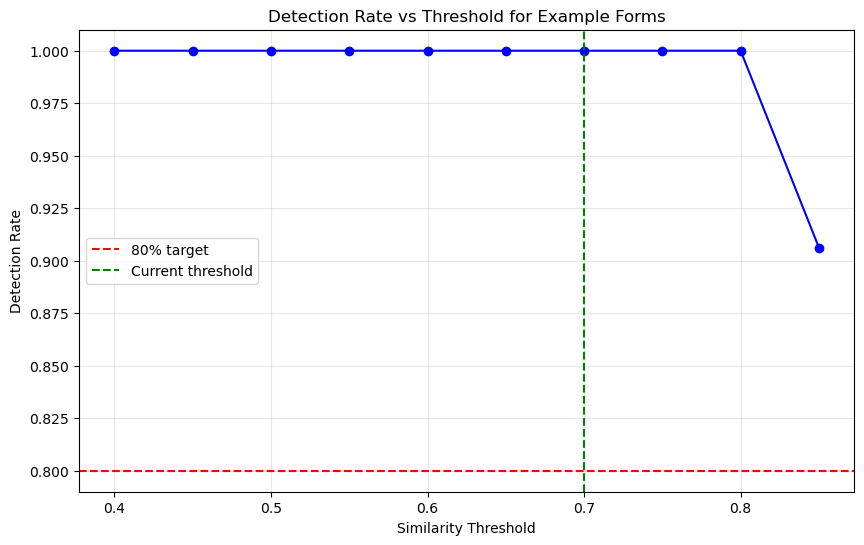


Optimal threshold for 80% detection: 0.40


In [11]:
# Test different thresholds
thresholds = np.arange(0.4, 0.9, 0.05)
detection_rates = []

for thresh in thresholds:
    detected = 0
    for i, test_features in enumerate(example_features):
        other_features = example_features[:i] + example_features[i+1:]
        if other_features:
            max_sim = max(cosine_similarity(test_features, other_feat)[0][0] 
                         for other_feat in other_features)
            if max_sim > thresh:
                detected += 1
    
    detection_rate = detected / len(example_features)
    detection_rates.append(detection_rate)
    print(f"Threshold {thresh:.2f}: {detection_rate:.1%} detection rate")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, detection_rates, 'b-o')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% target')
plt.axvline(x=0.7, color='g', linestyle='--', label='Current threshold')
plt.xlabel('Similarity Threshold')
plt.ylabel('Detection Rate')
plt.title('Detection Rate vs Threshold for Example Forms')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find optimal threshold
optimal_idx = np.argmax(np.array(detection_rates) >= 0.8)
if detection_rates[optimal_idx] >= 0.8:
    optimal_threshold = thresholds[optimal_idx]
    print(f"\nOptimal threshold for 80% detection: {optimal_threshold:.2f}")
else:
    print("\nNo threshold achieves 80% detection rate")

In [13]:
# Load some negative examples
nonexample_dir = "../../data/raw/_nonexamples/"
nonexample_features = []

if os.path.exists(nonexample_dir):
    nonexample_files = [f for f in os.listdir(nonexample_dir) if f.endswith('.pdf')][:5]  # Just first 5
    
    for nonexample_file in nonexample_files:
        try:
            pdf_path = os.path.join(nonexample_dir, nonexample_file)
            pdf = fitz.open(pdf_path)
            page = pdf[0]
            pix = page.get_pixmap()
            img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
            pdf.close()
            
            inputs = clip_processor(images=img, return_tensors="pt").to(device)
            with torch.no_grad():
                features = clip_model.get_image_features(**inputs)
                features = features.cpu().numpy()
                features = features / np.linalg.norm(features, axis=1, keepdims=True)
                
            nonexample_features.append(features)
            
        except Exception as e:
            print(f"Error loading {nonexample_file}: {e}")

print(f"Loaded {len(nonexample_features)} non-examples")

Loaded 5 non-examples


In [15]:
# Check similarity between examples and non-examples
if nonexample_features:
    print("Checking if examples are distinguishable from non-examples:\n")
    
    # For each example, find max similarity to non-examples
    for i, (ex_feat, ex_name) in enumerate(zip(example_features[:5], example_names[:5])):
        sims_to_nonexamples = []
        for nonex_feat in nonexample_features:
            sim = cosine_similarity(ex_feat, nonex_feat)[0][0]
            sims_to_nonexamples.append(sim)
        
        max_sim_to_nonex = max(sims_to_nonexamples)
        print(f"Example {ex_name[:20]:20s} | Max sim to non-examples: {max_sim_to_nonex:.3f}")
    
    print("\nIf these values are high (>0.7), examples and non-examples are too similar")

Checking if examples are distinguishable from non-examples:

Example 25581-000.pdf        | Max sim to non-examples: 0.645
Example 99171-000.pdf        | Max sim to non-examples: 0.739
Example 13924-002.pdf        | Max sim to non-examples: 0.738
Example 1197-000.pdf         | Max sim to non-examples: 0.728
Example 67419-000.pdf        | Max sim to non-examples: 0.788

If these values are high (>0.7), examples and non-examples are too similar


In [17]:
# Analyze feature statistics
print("Analyzing feature characteristics:\n")

# Stack all example features
all_features = np.vstack(example_features)

# Feature statistics
print(f"Feature dimensions: {all_features.shape}")
print(f"Feature mean: {np.mean(all_features):.4f}")
print(f"Feature std: {np.std(all_features):.4f}")
print(f"Feature min: {np.min(all_features):.4f}")
print(f"Feature max: {np.max(all_features):.4f}")

# Check if features are properly normalized
norms = np.linalg.norm(all_features, axis=1)
print(f"\nFeature norms: min={np.min(norms):.4f}, max={np.max(norms):.4f}")
print(f"All normalized to 1.0: {np.allclose(norms, 1.0)}")

Analyzing feature characteristics:

Feature dimensions: (32, 768)
Feature mean: -0.0011
Feature std: 0.0361
Feature min: -0.4122
Feature max: 0.4415

Feature norms: min=1.0000, max=1.0000
All normalized to 1.0: True


In [19]:
# Try alternative similarity metrics
print("Testing alternative similarity metrics:\n")

# Pick two examples
if len(example_features) >= 2:
    feat1, feat2 = example_features[0], example_features[1]
    
    # Cosine similarity
    cos_sim = cosine_similarity(feat1, feat2)[0][0]
    print(f"Cosine similarity: {cos_sim:.4f}")
    
    # Euclidean distance
    euclidean_dist = np.linalg.norm(feat1 - feat2)
    print(f"Euclidean distance: {euclidean_dist:.4f}")
    
    # Dot product (same as cosine for normalized vectors)
    dot_prod = np.dot(feat1.flatten(), feat2.flatten())
    print(f"Dot product: {dot_prod:.4f}")
    
    print("\nFor normalized vectors, cosine similarity = dot product")

Testing alternative similarity metrics:

Cosine similarity: 0.8266
Euclidean distance: 0.5889
Dot product: 0.8266

For normalized vectors, cosine similarity = dot product


In [21]:
# Final recommendation
print("=== RECOMMENDATIONS ===")
print("\nBased on the analysis:")

if avg_similarity < 0.6:
    print("1. Your example forms are too diverse. Consider:")
    print("   - Grouping similar forms together")
    print("   - Creating separate detectors for different form types")
    print("   - Adding more examples of each type")

if optimal_threshold < 0.7:
    print(f"\n2. Lower the similarity threshold to {optimal_threshold:.2f}")
    
if len(example_features) < 10:
    print("\n3. Add more example forms. You currently have too few examples.")

print("\n4. Alternative approaches to consider:")
print("   - Fine-tune CLIP on your specific forms")
print("   - Use a document-specific model like LayoutLMv3")
print("   - Combine visual features with text detection")
print("   - Use traditional CV methods (template matching, edge detection)")

=== RECOMMENDATIONS ===

Based on the analysis:

2. Lower the similarity threshold to 0.40

4. Alternative approaches to consider:
   - Fine-tune CLIP on your specific forms
   - Use a document-specific model like LayoutLMv3
   - Combine visual features with text detection
   - Use traditional CV methods (template matching, edge detection)
